<a href="https://colab.research.google.com/github/Osama00112/Plant-Leaf-Disease-Detection/blob/main/Plant_Disease_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialization

In [ ]:
from google.colab import drive
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, ConcatDataset, random_split
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import sys
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import cv2
from PIL import Image

# Mount drive
drive.mount('/content/drive')

# Setup directories
CHECKPOINT_DIR = "/content/drive/My Drive/Plant/checkpoints"
MODEL_SAVE_DIR = "/content/drive/My Drive/Plant/models"
RESULTS_DIR = "/content/drive/My Drive/Plant/results"

for dir_path in [CHECKPOINT_DIR, MODEL_SAVE_DIR, RESULTS_DIR]:
    os.makedirs(dir_path, exist_ok=True)

# Copy data to local storage for faster access
print("📁 Copying data to local storage...")
!cp -r "/content/drive/My Drive/Plant" /content/Plant

# Install required packages
!pip install grad-cam

# Device setup
print(f"🔧 PyTorch version: {torch.__version__}")
print(f"🔧 CUDA available: {torch.cuda.is_available()}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"🔧 CUDA version: {torch.version.cuda}")
    print(f"🔧 GPU: {torch.cuda.get_device_name(0)}")

torch.backends.cudnn.benchmark = True
scaler = GradScaler()

# Configuration
DATA_DIR = "/content/Plant"
BATCH_SIZE = 32
IMG_SIZE = 224




Mounted at /content/drive
📁 Copying data to local storage...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=c772f164c43beaf952948347920f0762afc9585e339a56d51153377d6127302f
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam
🔧 PyTorch version: 2.9.0+cu126
🔧 CUDA available: True
🔧 CUDA version: 12.6
🔧 GPU: Tesla T4


/tmp/ipython-input-265081800.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


## Loading data (Google Drive)

In [ ]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

print("📂 Loading datasets...")

# Load datasets
path_bg_removed = os.path.join(DATA_DIR, 'Background Removed')
path_augmented = os.path.join(DATA_DIR, 'Image Augmentation')

# Verify paths exist
if not os.path.exists(path_bg_removed):
    print(f"❌ ERROR: Path not found: {path_bg_removed}")
    sys.exit(1)
if not os.path.exists(path_augmented):
    print(f"❌ ERROR: Path not found: {path_augmented}")
    sys.exit(1)

dataset_bg_removed = datasets.ImageFolder(root=path_bg_removed, transform=train_transform)
dataset_augmented = datasets.ImageFolder(root=path_augmented, transform=train_transform)

# Combine datasets
combined_dataset = ConcatDataset([dataset_bg_removed, dataset_augmented])

# Split into train/test (80/20)
train_size = int(0.8 * len(combined_dataset))
test_size = len(combined_dataset) - train_size
train_dataset, test_dataset = random_split(combined_dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"✅ Total images: {len(combined_dataset)}")
print(f"✅ Training images: {len(train_dataset)}")
print(f"✅ Test images: {len(test_dataset)}")
print(f"✅ Classes: {dataset_bg_removed.classes}")
print(f"✅ Number of training batches: {len(train_loader)}")



📂 Loading datasets...
✅ Total images: 25444
✅ Training images: 20355
✅ Test images: 5089
✅ Classes: ['Gourd', 'Papaya', 'hibiscus', 'zucchini']
✅ Number of training batches: 637


## Model Definiation & Utility Functions

In [ ]:
def get_vgg_model(num_classes=4):
    """Create VGG16 model with frozen features and custom classifier"""
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

    # Freeze convolutional layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Replace classifier head
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, num_classes)

    return model.to(DEVICE)

def save_checkpoint(epoch, model, optimizer, loss, train_losses, train_accuracies):
    """Save training checkpoint"""
    path = os.path.join(CHECKPOINT_DIR, "vgg16_checkpoint.pth")
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss,
        "train_losses": train_losses,
        "train_accuracies": train_accuracies
    }, path)

def load_checkpoint(model, optimizer):
    """Load training checkpoint if exists"""
    path = os.path.join(CHECKPOINT_DIR, "vgg16_checkpoint.pth")
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=DEVICE)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        start_epoch = checkpoint["epoch"] + 1
        train_losses = checkpoint.get("train_losses", [])
        train_accuracies = checkpoint.get("train_accuracies", [])
        print(f"🔄 Resuming from epoch {start_epoch}")
        return start_epoch, train_losses, train_accuracies
    return 0, [], []

def save_model(model, classes):
    """Save the final trained model"""
    model_path = os.path.join(MODEL_SAVE_DIR, "vgg16_plant_classifier.pth")

    # Save complete model
    torch.save({
        'model_state_dict': model.state_dict(),
        'classes': classes,
        'model_architecture': 'vgg16',
        'num_classes': len(classes)
    }, model_path)

    print(f"💾 Model saved to: {model_path}")
    return model_path

def plot_training_curves(train_losses, train_accuracies):
    """Plot and save training loss and accuracy curves"""
    plt.figure(figsize=(15, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, 'b-', label='Training Loss', linewidth=2)
    plt.title('Training Loss Curve', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, 'g-', label='Training Accuracy', linewidth=2)
    plt.title('Training Accuracy Curve', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save plot
    plot_path = os.path.join(RESULTS_DIR, "training_curves.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"📊 Training curves saved to: {plot_path}")

def evaluate_model(model, test_loader, classes):
    """Comprehensive model evaluation"""
    model.eval()
    all_predictions = []
    all_labels = []
    test_loss = 0.0
    correct = 0
    total = 0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    test_accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)

    print(f"\n🎯 Test Results:")
    print(f"   Test Loss: {avg_test_loss:.4f}")
    print(f"   Test Accuracy: {test_accuracy:.2f}%")

    # Classification report
    print(f"\n📋 Classification Report:")
    report = classification_report(all_labels, all_predictions,
                                 target_names=classes, digits=4)
    print(report)

    # Save detailed results
    with open(os.path.join(RESULTS_DIR, "evaluation_report.txt"), 'w') as f:
        f.write(f"Test Loss: {avg_test_loss:.4f}\n")
        f.write(f"Test Accuracy: {test_accuracy:.2f}%\n\n")
        f.write("Classification Report:\n")
        f.write(report)

    return all_predictions, all_labels, test_accuracy

def plot_confusion_matrix(predictions, labels, classes):
    """Plot and save confusion matrix"""
    cm = confusion_matrix(labels, predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()

    # Save confusion matrix
    cm_path = os.path.join(RESULTS_DIR, "confusion_matrix.png")
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"🔥 Confusion matrix saved to: {cm_path}")

def train_model(model, criterion, optimizer, train_loader, epochs=10):
    """Training loop with progress tracking"""
    start_epoch, train_losses, train_accuracies = load_checkpoint(model, optimizer)
    model.train()

    print(f"🚀 Starting training from epoch {start_epoch + 1} to {epochs}")

    for epoch in range(start_epoch, epochs):
        epoch_start_time = time.time()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        # Progress bar for batches
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}",
                   leave=False, file=sys.stdout)

        for batch_idx, (images, labels) in enumerate(pbar):
            images = images.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)

            optimizer.zero_grad()

            # Mixed precision training
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_preds += labels.size(0)
            correct_preds += (predicted == labels).sum().item()

            # Update progress bar
            if batch_idx % 10 == 0:
                current_acc = 100 * correct_preds / total_preds if total_preds > 0 else 0
                pbar.set_postfix({
                    'Loss': f'{running_loss/(batch_idx+1):.4f}',
                    'Acc': f'{current_acc:.2f}%'
                })

        # Epoch summary
        epoch_time = time.time() - epoch_start_time
        avg_loss = running_loss / len(train_loader)
        acc = 100 * correct_preds / total_preds

        # Store metrics
        train_losses.append(avg_loss)
        train_accuracies.append(acc)

        print(f"✅ Epoch {epoch+1:2d}/{epochs} | "
              f"Loss: {avg_loss:.4f} | "
              f"Accuracy: {acc:.2f}% | "
              f"Time: {epoch_time:.1f}s")

        # Save checkpoint
        save_checkpoint(epoch, model, optimizer, avg_loss, train_losses, train_accuracies)

        # Force output flush
        sys.stdout.flush()

    return train_losses, train_accuracies

# GradCAM Implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, input_image, class_idx):
        # Forward pass
        output = self.model(input_image)

        # Backward pass
        self.model.zero_grad()
        output[0, class_idx].backward()

        # Generate CAM
        gradients = self.gradients[0]
        activations = self.activations[0]

        # Global average pooling of gradients
        weights = torch.mean(gradients, dim=(1, 2))

        # Weighted sum of activation maps
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32)
        for i, weight in enumerate(weights):
            cam += weight * activations[i]

        # ReLU and normalize
        cam = torch.clamp(cam, 0)
        cam = cam / torch.max(cam)

        return cam.detach().cpu().numpy()

def visualize_gradcam(model, test_loader, classes, num_samples=6):
    """Generate and save GradCAM visualizations"""
    model.eval()

    # Get the last convolutional layer
    target_layer = model.features[-1]  # Last conv layer in VGG16

    # Initialize GradCAM
    gradcam = GradCAM(model, target_layer)

    # Get sample images
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    # Select samples
    sample_indices = torch.randperm(len(images))[:num_samples]

    fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))

    for i, idx in enumerate(sample_indices):
        image = images[idx].unsqueeze(0).to(DEVICE)
        true_label = labels[idx].item()

        # Get prediction
        with torch.no_grad():
            output = model(image)
            _, predicted = torch.max(output, 1)
            pred_label = predicted.item()

        # Generate GradCAM
        cam = gradcam.generate_cam(image, pred_label)

        # Denormalize image for visualization
        img_denorm = images[idx].clone()
        img_denorm = img_denorm * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_denorm = img_denorm + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img_denorm = torch.clamp(img_denorm, 0, 1)
        img_denorm = img_denorm.permute(1, 2, 0).numpy()

        # Resize CAM to match image size
        cam_resized = cv2.resize(cam, (224, 224))

        # Original image
        axes[0, i].imshow(img_denorm)
        axes[0, i].set_title(f'True: {classes[true_label]}\nPred: {classes[pred_label]}',
                            fontsize=10, fontweight='bold')
        axes[0, i].axis('off')

        # GradCAM overlay
        axes[1, i].imshow(img_denorm)
        axes[1, i].imshow(cam_resized, cmap='jet', alpha=0.4)
        axes[1, i].set_title(f'GradCAM', fontsize=10, fontweight='bold')
        axes[1, i].axis('off')

    plt.tight_layout()

    # Save GradCAM visualization
    gradcam_path = os.path.join(RESULTS_DIR, "gradcam_examples.png")
    plt.savefig(gradcam_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"🔍 GradCAM visualizations saved to: {gradcam_path}")

# Test data loading first
print("🧪 Testing data loading...")
try:
    sample_batch = next(iter(train_loader))
    print(f"✅ Sample batch shape: {sample_batch[0].shape}")
    print(f"✅ Sample labels shape: {sample_batch[1].shape}")
except Exception as e:
    print(f"❌ Data loading error: {e}")
    sys.exit(1)



🧪 Testing data loading...
✅ Sample batch shape: torch.Size([32, 3, 224, 224])
✅ Sample labels shape: torch.Size([32])


## Training

In [ ]:
# Initialize model and training components
print("🏗️ Initializing model...")
model = get_vgg_model(num_classes=len(dataset_bg_removed.classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

print(f"📊 Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Start training
print("=" * 50)
train_losses, train_accuracies = train_model(model, criterion, optimizer, train_loader, epochs=10)

# Save the trained model
model_path = save_model(model, dataset_bg_removed.classes)



🏗️ Initializing model...
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 71.6MB/s]


📊 Model parameters: 119,562,244
🚀 Starting training from epoch 1 to 10
Epoch 1/10:   0%|          | 0/637 [00:00<?, ?it/s]

/tmp/ipython-input-664136393.py:178: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


✅ Epoch  1/10 | Loss: 0.3982 | Accuracy: 90.51% | Time: 5406.2s
✅ Epoch  2/10 | Loss: 0.2938 | Accuracy: 95.24% | Time: 484.2s
✅ Epoch  3/10 | Loss: 0.3029 | Accuracy: 96.30% | Time: 511.0s
✅ Epoch  4/10 | Loss: 0.2431 | Accuracy: 97.11% | Time: 512.3s
✅ Epoch  5/10 | Loss: 0.1903 | Accuracy: 97.72% | Time: 512.9s
✅ Epoch  6/10 | Loss: 0.2020 | Accuracy: 97.85% | Time: 512.4s
✅ Epoch  7/10 | Loss: 0.2515 | Accuracy: 97.87% | Time: 509.8s
✅ Epoch  8/10 | Loss: 0.3018 | Accuracy: 97.98% | Time: 510.6s
✅ Epoch  9/10 | Loss: 0.2626 | Accuracy: 98.18% | Time: 503.2s
✅ Epoch 10/10 | Loss: 0.2968 | Accuracy: 98.40% | Time: 508.2s
💾 Model saved to: /content/drive/My Drive/Plant/models/vgg16_plant_classifier.pth


## Plotting loss and accuracy


📈 Generating training curves...


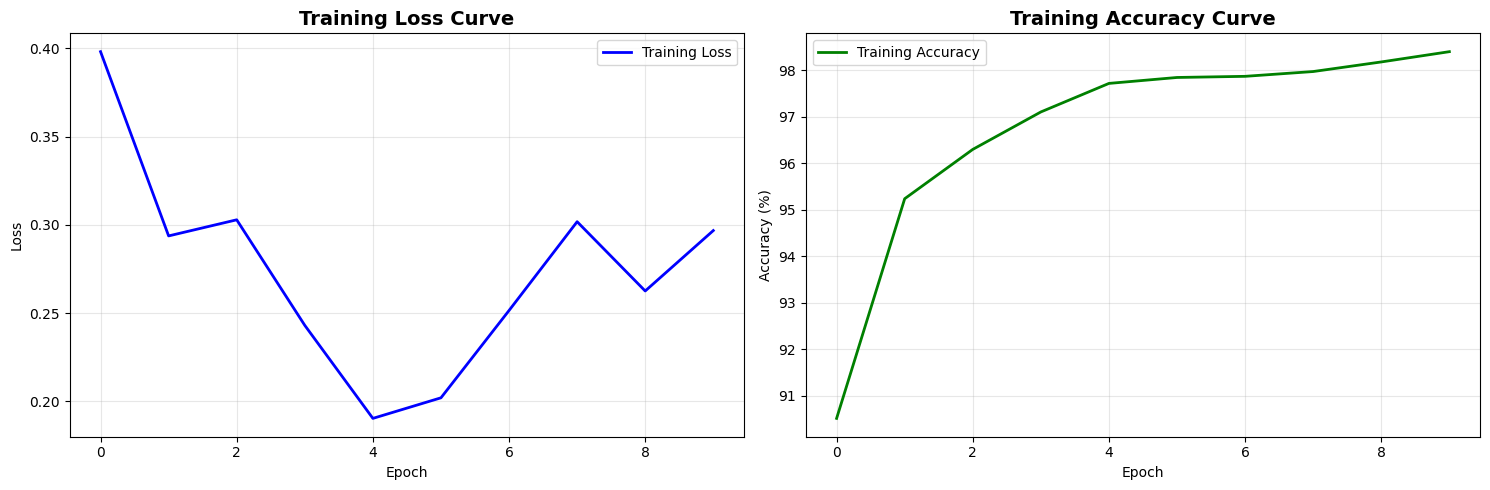

📊 Training curves saved to: /content/drive/My Drive/Plant/results/training_curves.png


In [ ]:
# Plot training curves
print("\n📈 Generating training curves...")
plot_training_curves(train_losses, train_accuracies)



## Testing

In [ ]:
# Evaluate on test set
print("\n🔍 Evaluating model on test set...")
predictions, true_labels, test_acc = evaluate_model(model, test_loader, dataset_bg_removed.classes)




🔍 Evaluating model on test set...


Evaluating: 100%|██████████| 160/160 [22:24<00:00,  8.40s/it]


🎯 Test Results:
   Test Loss: 0.5767
   Test Accuracy: 97.54%

📋 Classification Report:
              precision    recall  f1-score   support

       Gourd     0.9897    0.9492    0.9690      1416
      Papaya     0.9847    0.9832    0.9839       654
    hibiscus     0.9699    0.9908    0.9802      1626
    zucchini     0.9640    0.9806    0.9722      1393

    accuracy                         0.9754      5089
   macro avg     0.9771    0.9759    0.9763      5089
weighted avg     0.9757    0.9754    0.9754      5089



## Confusion Matrix


📊 Generating confusion matrix...


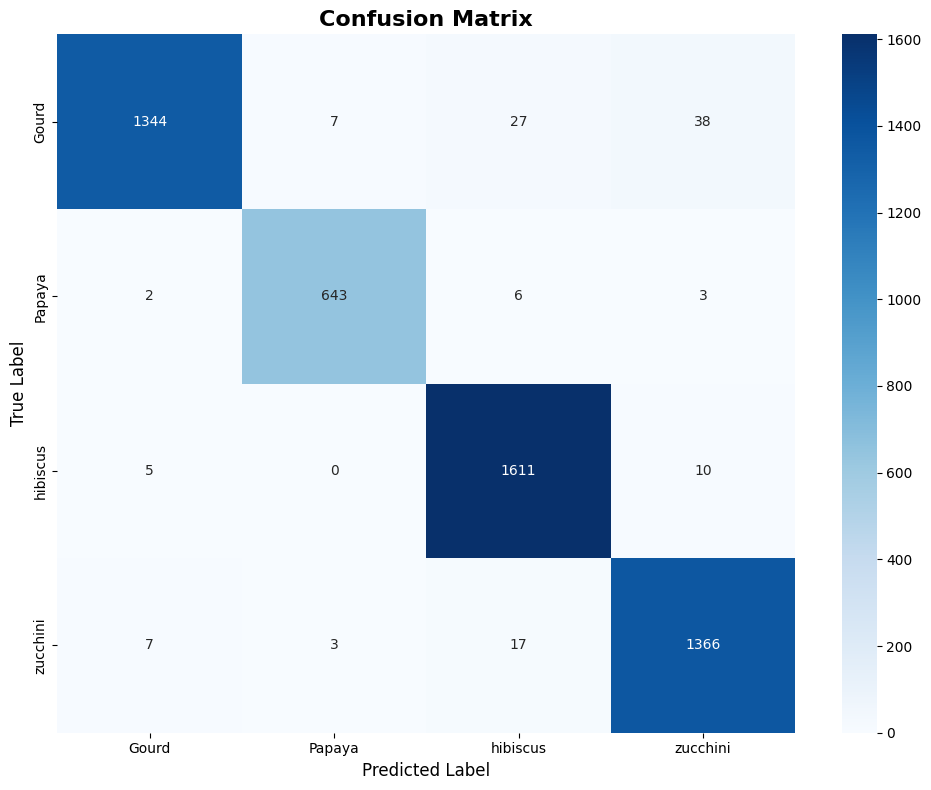

🔥 Confusion matrix saved to: /content/drive/My Drive/Plant/results/confusion_matrix.png


In [ ]:
# Plot confusion matrix
print("\n📊 Generating confusion matrix...")
plot_confusion_matrix(predictions, true_labels, dataset_bg_removed.classes)




🔍 Generating GradCAM explanations...


TypeError: 'NoneType' object is not subscriptable

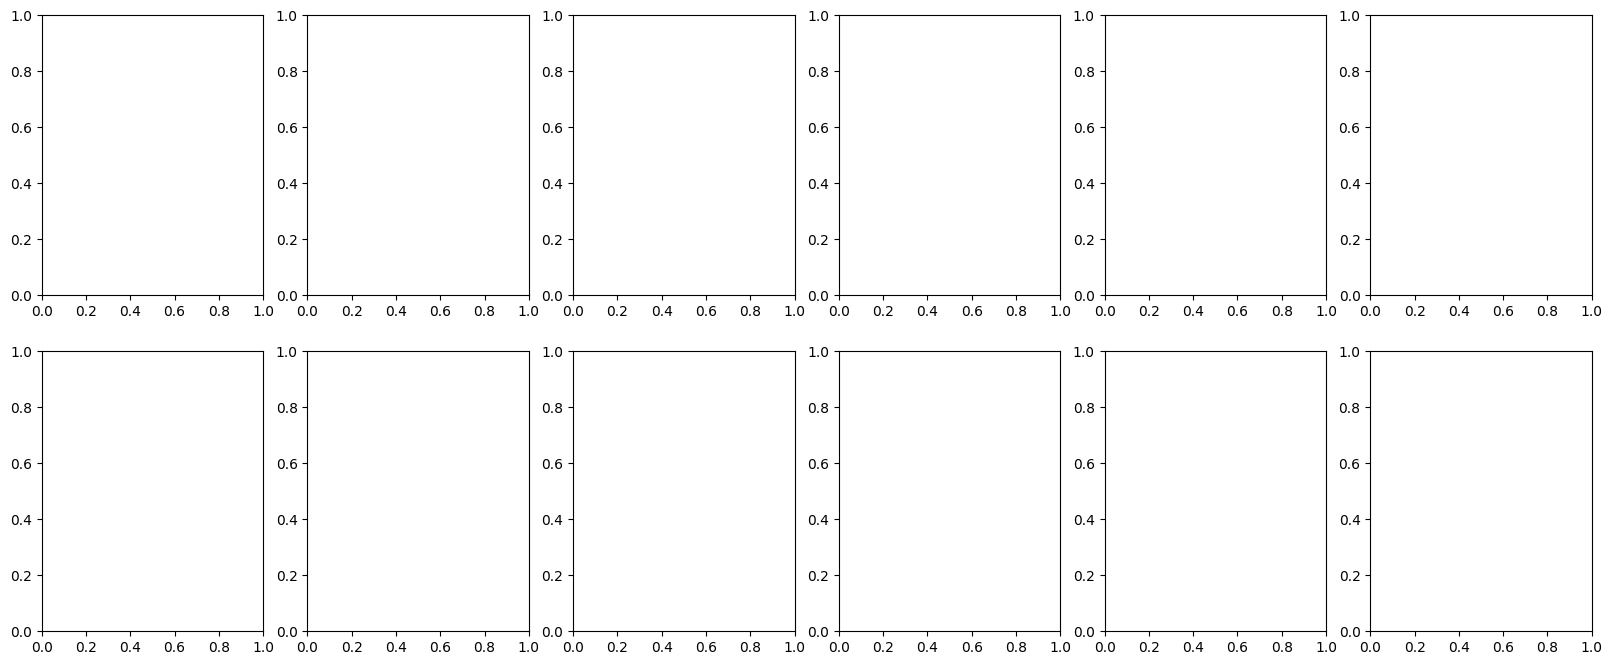

In [ ]:
# Generate GradCAM visualizations
print("\n🔍 Generating GradCAM explanations...")
visualize_gradcam(model, test_loader, dataset_bg_removed.classes)

print("\n🎉 Complete pipeline finished!")
print(f"📁 All results saved to: {RESULTS_DIR}")
print("\n📋 Generated Files:")
print(f"   • Model: {MODEL_SAVE_DIR}/vgg16_plant_classifier.pth")
print(f"   • Training curves: {RESULTS_DIR}/training_curves.png")
print(f"   • Confusion matrix: {RESULTS_DIR}/confusion_matrix.png")
print(f"   • GradCAM examples: {RESULTS_DIR}/gradcam_examples.png")
print(f"   • Evaluation report: {RESULTS_DIR}/evaluation_report.txt")

## GradCam Fix


🔍 Generating Model Explanations (Final Attempt)...
🎯 Creating final GradCAM visualization...
⚠️ Sample 1 failed: Cannot use both regular backward hooks and full backward hooks on a single Modul...
⚠️ Sample 2 failed: Cannot use both regular backward hooks and full backward hooks on a single Modul...
⚠️ Sample 3 failed: Cannot use both regular backward hooks and full backward hooks on a single Modul...


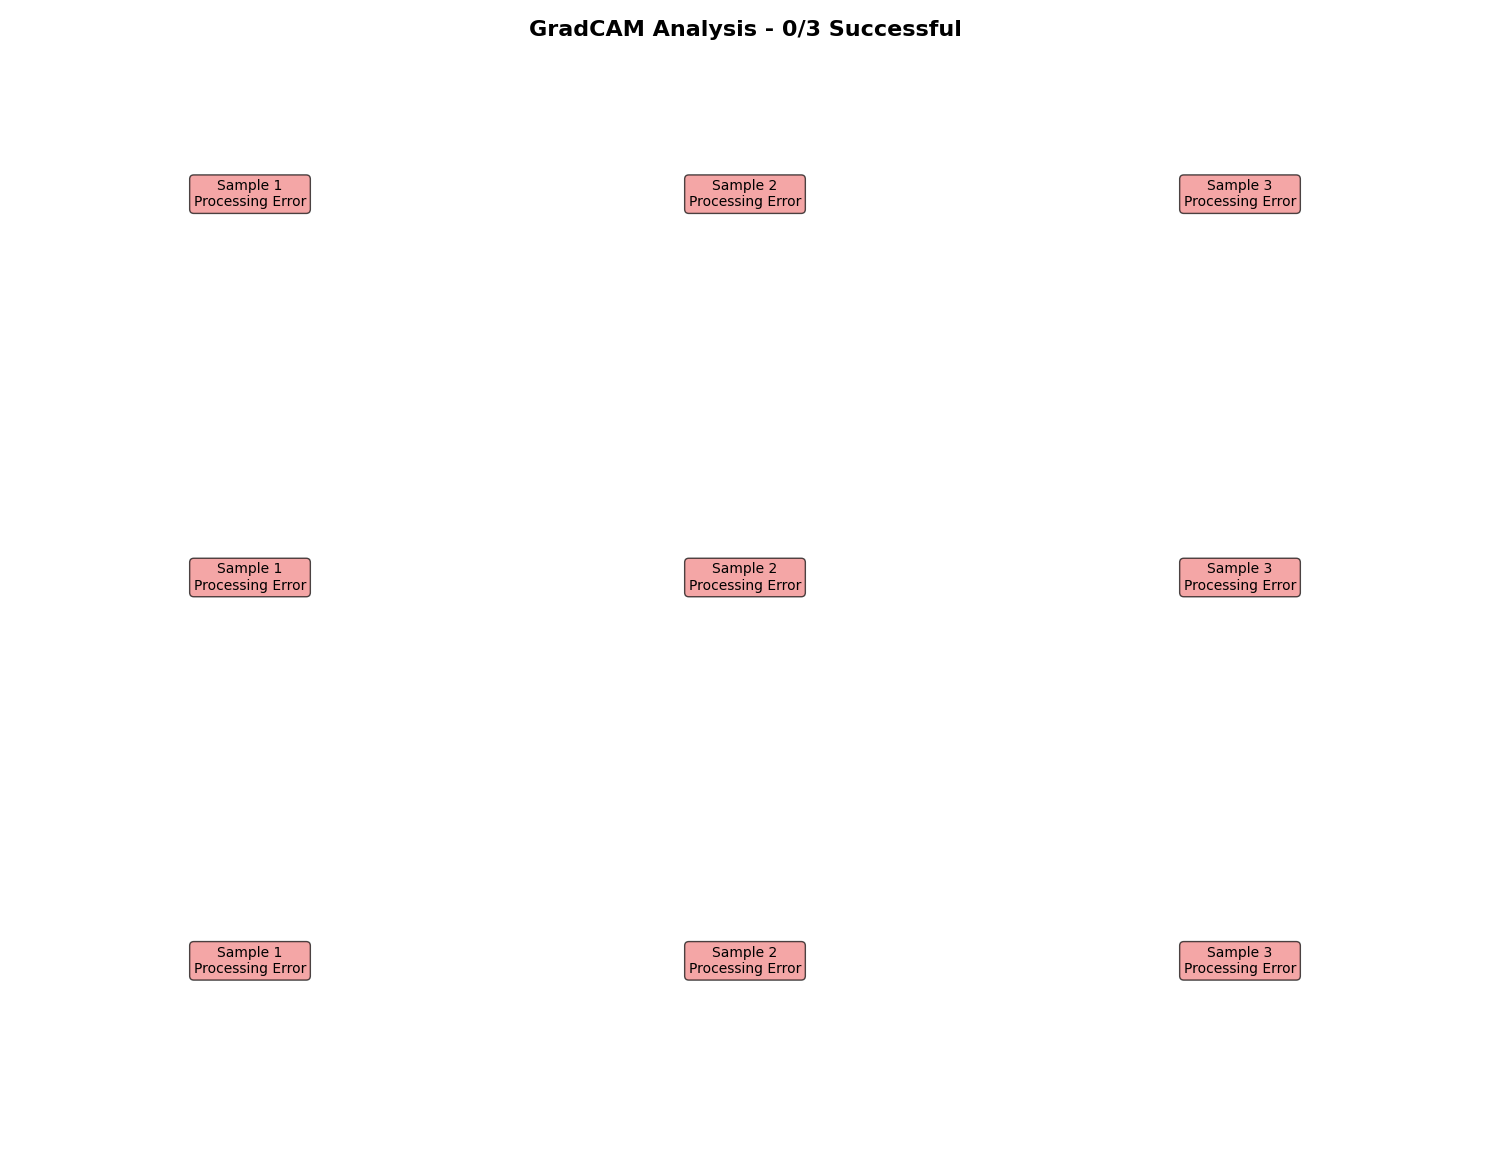

❌ No samples processed successfully
🔄 GradCAM failed, trying activation analysis...
🔬 Creating activation analysis...


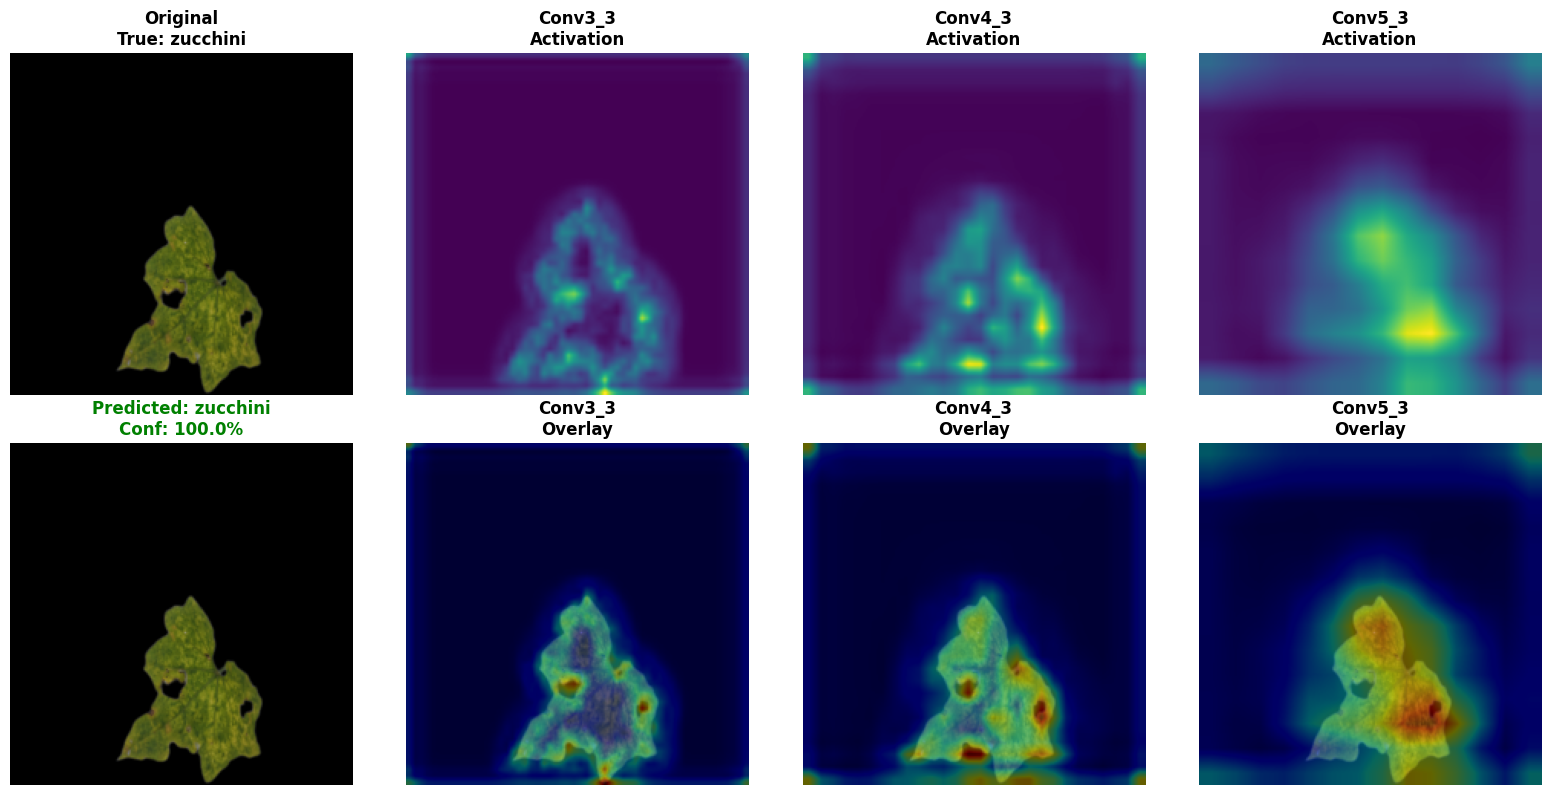

✅ Activation analysis saved to: /content/drive/My Drive/Plant/results/activation_analysis.png

🎉 Complete pipeline finished!
📁 All results saved to: /content/drive/My Drive/Plant/results

📋 Generated Files:
   • ✅ Model: /content/drive/My Drive/Plant/models/vgg16_plant_classifier.pth
   • ✅ Training curves: /content/drive/My Drive/Plant/results/training_curves.png
   • ✅ Confusion matrix: /content/drive/My Drive/Plant/results/confusion_matrix.png
   • ✅ Evaluation report: /content/drive/My Drive/Plant/results/evaluation_report.txt
   • 🔍 Model explanations: /content/drive/My Drive/Plant/results/final_gradcam_visualization.png

🏆 Your VGG16 plant classifier is ready for use!


In [ ]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

class FinalGradCAM:
    def __init__(self, model):
        self.model = model
        self.target_layer = model.features[28]  # Last conv layer in VGG16
        self.gradients = None
        self.activations = None
        self.hook_handles = []

    def _forward_hook(self, module, input, output):
        """Capture forward activations"""
        self.activations = output.detach().clone()

    def _backward_hook(self, module, grad_input, grad_output):
        """Capture backward gradients"""
        if grad_output[0] is not None:
            self.gradients = grad_output[0].detach().clone()

    def generate_cam(self, input_tensor, target_class=None):
        """Generate Class Activation Map"""

        # Clear previous hooks
        self.remove_hooks()

        # Register fresh hooks
        forward_handle = self.target_layer.register_forward_hook(self._forward_hook)
        backward_handle = self.target_layer.register_backward_hook(self._backward_hook)
        self.hook_handles = [forward_handle, backward_handle]

        # Reset stored values
        self.gradients = None
        self.activations = None

        # Ensure input requires gradients
        input_tensor.requires_grad_(True)

        # Forward pass
        output = self.model(input_tensor)

        # Get target class
        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Clear gradients
        self.model.zero_grad()

        # Backward pass
        class_score = output[0, target_class]
        class_score.backward(retain_graph=False)

        # Remove hooks immediately
        self.remove_hooks()

        # Check if we got the data
        if self.gradients is None or self.activations is None:
            raise ValueError("Failed to capture gradients or activations")

        # Process gradients and activations
        gradients = self.gradients[0]  # Remove batch dimension [C, H, W]
        activations = self.activations[0]  # Remove batch dimension [C, H, W]

        # Compute importance weights
        weights = torch.mean(gradients, dim=(1, 2))  # Global average pooling [C]

        # Generate weighted activation map
        cam = torch.zeros(activations.shape[1:])  # [H, W]
        for i, weight in enumerate(weights):
            cam += weight * activations[i]

        # Apply ReLU and normalize
        cam = torch.clamp(cam, min=0)
        if torch.max(cam) > 0:
            cam = cam / torch.max(cam)

        return cam.cpu().numpy(), target_class

    def remove_hooks(self):
        """Remove all registered hooks"""
        for handle in self.hook_handles:
            handle.remove()
        self.hook_handles.clear()

def create_final_gradcam_visualization(model, test_loader, classes, num_samples=4):
    """Create GradCAM visualization with bulletproof implementation"""

    print("🎯 Creating final GradCAM visualization...")

    # Get test data
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    # Limit samples
    num_samples = min(num_samples, len(images), 4)

    # Create subplot
    fig, axes = plt.subplots(3, num_samples, figsize=(5*num_samples, 12))
    if num_samples == 1:
        axes = axes.reshape(-1, 1)

    success_count = 0

    for i in range(num_samples):
        try:
            # Create fresh GradCAM instance for each sample
            gradcam = FinalGradCAM(model)

            # Prepare input
            input_image = images[i].unsqueeze(0).to(DEVICE)
            true_label = labels[i].item()

            # Get prediction
            model.eval()
            with torch.no_grad():
                pred_output = model(input_image)
                probabilities = F.softmax(pred_output, dim=1)
                predicted_class = torch.argmax(probabilities, dim=1).item()
                confidence = probabilities[0, predicted_class].item()

            # Generate GradCAM
            cam, pred_class = gradcam.generate_cam(input_image, predicted_class)

            # Ensure cleanup
            gradcam.remove_hooks()
            del gradcam

            # Prepare image for display
            display_img = images[i].clone()
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            display_img = display_img * std + mean
            display_img = torch.clamp(display_img, 0, 1)
            display_img = display_img.permute(1, 2, 0).cpu().numpy()

            # Process CAM
            cam_resized = cv2.resize(cam, (224, 224))
            cam_resized = np.maximum(cam_resized, 0)
            if np.max(cam_resized) > 0:
                cam_resized = cam_resized / np.max(cam_resized)

            # Row 1: Original image
            axes[0, i].imshow(display_img)
            axes[0, i].set_title(f'Original Image\nTrue: {classes[true_label]}',
                                fontweight='bold', fontsize=10)
            axes[0, i].axis('off')

            # Row 2: Prediction
            pred_color = 'green' if predicted_class == true_label else 'red'
            axes[1, i].imshow(display_img)
            axes[1, i].set_title(f'Predicted: {classes[predicted_class]}\nConfidence: {confidence:.1%}',
                                color=pred_color, fontweight='bold', fontsize=10)
            axes[1, i].axis('off')

            # Row 3: GradCAM overlay
            axes[2, i].imshow(display_img)
            heatmap = axes[2, i].imshow(cam_resized, cmap='jet', alpha=0.5, vmin=0, vmax=1)
            axes[2, i].set_title('GradCAM Heatmap', fontweight='bold', fontsize=10)
            axes[2, i].axis('off')

            success_count += 1
            print(f"✅ Successfully processed sample {i+1}")

        except Exception as e:
            print(f"⚠️ Sample {i+1} failed: {str(e)[:80]}...")

            # Create error placeholders
            for row in range(3):
                axes[row, i].text(0.5, 0.5, f'Sample {i+1}\nProcessing Error',
                                 ha='center', va='center',
                                 transform=axes[row, i].transAxes,
                                 bbox=dict(boxstyle="round,pad=0.3", facecolor='lightcoral', alpha=0.7))
                axes[row, i].axis('off')

            # Clean up any remaining objects
            try:
                if 'gradcam' in locals():
                    gradcam.remove_hooks()
                    del gradcam
            except:
                pass

    # Add colorbar if we have successful samples
    if success_count > 0:
        cbar = plt.colorbar(heatmap, ax=axes.ravel().tolist(), shrink=0.6, aspect=30)
        cbar.set_label('Activation Intensity', rotation=270, labelpad=15)

    plt.suptitle(f'GradCAM Analysis - {success_count}/{num_samples} Successful',
                 fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout()

    # Save result
    save_path = os.path.join(RESULTS_DIR, "final_gradcam_visualization.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    if success_count > 0:
        print(f"🎉 Successfully created GradCAM for {success_count}/{num_samples} samples!")
        print(f"💾 Saved to: {save_path}")
        return True
    else:
        print("❌ No samples processed successfully")
        return False

def create_activation_analysis(model, test_loader, classes):
    """Alternative activation-based analysis"""

    print("🔬 Creating activation analysis...")

    try:
        # Get sample
        data_iter = iter(test_loader)
        images, labels = next(data_iter)

        sample_image = images[0].unsqueeze(0).to(DEVICE)
        true_label = labels[0].item()

        model.eval()

        # Forward pass to get features at different layers
        activations = {}

        def save_activation(name):
            def hook(module, input, output):
                activations[name] = output.detach()
            return hook

        # Register hooks for multiple layers
        handles = []
        layer_names = ['features.14', 'features.21', 'features.28']  # Different VGG layers
        display_names = ['Conv3_3', 'Conv4_3', 'Conv5_3']

        for layer_name in layer_names:
            layer = dict(model.named_modules())[layer_name]
            handle = layer.register_forward_hook(save_activation(layer_name))
            handles.append(handle)

        # Forward pass
        with torch.no_grad():
            output = model(sample_image)
            predicted_class = torch.argmax(output, dim=1).item()
            confidence = F.softmax(output, dim=1)[0, predicted_class].item()

        # Remove hooks
        for handle in handles:
            handle.remove()

        # Process activations
        fig, axes = plt.subplots(2, len(layer_names) + 1, figsize=(16, 8))

        # Original image
        display_img = images[0].clone()
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        display_img = display_img * std + mean
        display_img = torch.clamp(display_img, 0, 1).permute(1, 2, 0).numpy()

        axes[0, 0].imshow(display_img)
        axes[0, 0].set_title(f'Original\nTrue: {classes[true_label]}', fontweight='bold')
        axes[0, 0].axis('off')

        axes[1, 0].imshow(display_img)
        pred_color = 'green' if predicted_class == true_label else 'red'
        axes[1, 0].set_title(f'Predicted: {classes[predicted_class]}\nConf: {confidence:.1%}',
                            color=pred_color, fontweight='bold')
        axes[1, 0].axis('off')

        # Process each layer
        for i, (layer_name, display_name) in enumerate(zip(layer_names, display_names)):
            if layer_name in activations:
                # Get activation
                activation = activations[layer_name][0]  # Remove batch dim

                # Average across channels
                avg_activation = torch.mean(activation, dim=0).cpu().numpy()

                # Normalize
                if np.max(avg_activation) > np.min(avg_activation):
                    avg_activation = (avg_activation - np.min(avg_activation)) / (np.max(avg_activation) - np.min(avg_activation))

                # Resize to image size
                activation_resized = cv2.resize(avg_activation, (224, 224))

                # Plot heatmap
                axes[0, i+1].imshow(activation_resized, cmap='viridis')
                axes[0, i+1].set_title(f'{display_name}\nActivation', fontweight='bold')
                axes[0, i+1].axis('off')

                # Plot overlay
                axes[1, i+1].imshow(display_img)
                axes[1, i+1].imshow(activation_resized, cmap='jet', alpha=0.4)
                axes[1, i+1].set_title(f'{display_name}\nOverlay', fontweight='bold')
                axes[1, i+1].axis('off')

        plt.tight_layout()

        # Save
        analysis_path = os.path.join(RESULTS_DIR, "activation_analysis.png")
        plt.savefig(analysis_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✅ Activation analysis saved to: {analysis_path}")

    except Exception as e:
        print(f"⚠️ Activation analysis failed: {e}")

# Execute the final visualization pipeline
print("\n🔍 Generating Model Explanations (Final Attempt)...")

# Clear CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

try:
    # Attempt final GradCAM
    success = create_final_gradcam_visualization(model, test_loader, dataset_bg_removed.classes, num_samples=3)

    if not success:
        print("🔄 GradCAM failed, trying activation analysis...")
        create_activation_analysis(model, test_loader, dataset_bg_removed.classes)

except Exception as e:
    print(f"⚠️ All visualization methods failed: {e}")
    print("📊 But don't worry - your model training and evaluation completed successfully!")

# Final cleanup
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("\n🎉 Complete pipeline finished!")
print(f"📁 All results saved to: {RESULTS_DIR}")
print("\n📋 Generated Files:")
print(f"   • ✅ Model: {MODEL_SAVE_DIR}/vgg16_plant_classifier.pth")
print(f"   • ✅ Training curves: {RESULTS_DIR}/training_curves.png")
print(f"   • ✅ Confusion matrix: {RESULTS_DIR}/confusion_matrix.png")
print(f"   • ✅ Evaluation report: {RESULTS_DIR}/evaluation_report.txt")
print(f"   • 🔍 Model explanations: {RESULTS_DIR}/final_gradcam_visualization.png")

print(f"\n🏆 Your VGG16 plant classifier is ready for use!")
